# SpectralNET Exploring Spatial Spectral Wavelet CNN for Hyper Spectral Image Classification

**Authors:** Tanmay CHAKRABORTY and Utkarsh TREHAN

In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from tensorflow.keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import add, concatenate
from keras.layers import AveragePooling2D
from keras.utils import plot_model
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import AveragePooling3D

2024-07-15 11:14:53.819636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 11:14:53.848146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 11:14:53.848190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 11:14:53.867385: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 11:14:54.820597: W tensorflow/com


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa
    

In [3]:
# def applyPCA(X, numComponents=75):
#     newX = np.reshape(X, (-1, X.shape[2]))
#     pca = PCA(n_components=numComponents, whiten=True)
#     newX = pca.fit_transform(newX)
#     newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
#     return newX, pca

In [4]:
## GLOBAL VARIABLES
dataset = 'HSN'
test_ratio = 0.95
windowSize = 12

In [5]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'HSN':
        data = sio.loadmat(os.path.join(data_path, '2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat'))['ans']
        labels = sio.loadmat(os.path.join(data_path, 'GRSS2013.mat'))['name']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

((349, 1905, 144), (349, 1905))

In [10]:
K = X.shape[2]

In [11]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(349, 1905, 3)

In [12]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((15029, 12, 12, 3), (15029,))

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((751, 12, 12, 3), (14278, 12, 12, 3), (751,), (14278,))

In [14]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(751, 12, 12, 3, 1)

In [15]:
ytrain = to_categorical(ytrain)
ytrain.shape

(751, 15)

In [16]:
S1 = windowSize
L1 = K
if (dataset == 'PU'):
    output_units = 9
elif (dataset == 'HSN'):
    output_units = 15
else:
    output_units = 16

In [17]:
class HSIVimBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, output_dim, delta_param_init):
        super(HSIVimBlock, self).__init__()
        self.hidden_dim = hidden_dim

        self.norm = layers.LayerNormalization()

        self.linear_x = layers.Dense(hidden_dim)
        self.linear_z = layers.Dense(hidden_dim)

        self.forward_conv1d = layers.Conv1D(hidden_dim, kernel_size=3, padding='same', activation='swish')
        self.backward_conv1d = layers.Conv1D(hidden_dim, kernel_size=3, padding='same', activation='swish')

        self.A = self.add_weight(shape=(hidden_dim, hidden_dim), initializer='random_normal', trainable=True)
        self.B = self.add_weight(shape=(hidden_dim, hidden_dim), initializer='random_normal', trainable=True)
        self.delta_param = self.add_weight(shape=(hidden_dim,), initializer=tf.keras.initializers.Constant(delta_param_init), trainable=True)

        self.linear_forward = layers.Dense(output_dim)
        self.linear_backward = layers.Dense(output_dim)

        self.residual_layer = layers.Dense(output_dim)

    def call(self, x):
        # x.shape = (Batch, Features)
        x_norm = self.norm(x)

        x_proj = self.linear_x(x_norm)
        z_proj = self.linear_z(x_norm)

        x_proj = tf.expand_dims(x_proj, axis=1)  # Shape: (Batch, 1, hidden_dim)
        z_proj = tf.expand_dims(z_proj, axis=1)  # Shape: (Batch, 1, hidden_dim)
        z_proj_reversed = tf.reverse(z_proj, axis=[1])

        delta_expanded = tf.expand_dims(tf.expand_dims(self.delta_param, 0), 0)

        forward_ssm_output = tf.tanh(self.forward_conv1d(x_proj) + tf.matmul(x_proj, self.A) * delta_expanded)
        backward_ssm_output = tf.tanh(self.backward_conv1d(z_proj_reversed) + tf.matmul(z_proj_reversed, self.B) * delta_expanded)

        forward_reduced = tf.reduce_mean(forward_ssm_output, axis=1)
        backward_reduced = tf.reduce_mean(backward_ssm_output, axis=1)

        y_forward = self.linear_forward(forward_reduced)
        y_backward = self.linear_backward(backward_reduced)

        y_combined = y_forward + y_backward

        # Adding residual connection
        y_residual = self.residual_layer(x)
        y_final = y_combined + y_residual

        return y_final
        
def build_model(input_shape, hidden_dim, output_dim, delta_param_init, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = HSIVimBlock(hidden_dim, output_dim, delta_param_init)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model


In [18]:
def get_wavelet_cnn_model():
 
    input_shape =  (12, 12, 3)
 
    input_ = Input(input_shape, name='the_input')
    
    # Reshape input to 3D
    reshaped_input = Reshape((12, 12, 3, 1))(input_)

    # Level one decomposition
    conv_1 = Conv3D(64, kernel_size=(3, 3, 3), padding='same', name='conv_1')(reshaped_input)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv3D(64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # Level two decomposition
    conv_2 = Conv3D(128, kernel_size=(3, 3, 3), padding='same', name='conv_2')(relu_1_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv3D(128, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # Level three decomposition
    conv_3 = Conv3D(256, kernel_size=(3, 3, 3), padding='same', name='conv_3')(relu_2_2)
    norm_3 = BatchNormalization(name='norm_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv3D(256, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # Level four decomposition
    conv_4 = Conv3D(256, kernel_size=(3, 3, 3), padding='same', name='conv_4')(relu_3_2)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv3D(256, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    # Classification head
    conv_5_1 = Conv3D(128, kernel_size=(3, 3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
    
    pool_5_1 = AveragePooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='same', name='avg_pool_5_1')(relu_5_1)
    flatten_layer = Flatten()(pool_5_1)
    
    hidden_dim = 256
    output_dim = 128
    delta_param_init = 0.01
    num_classes = output_units

    output_layer = build_model(flatten_layer.shape[1:], hidden_dim, output_dim, delta_param_init, num_classes)(flatten_layer)
    
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    return model

In [19]:
model = get_wavelet_cnn_model()

2024-07-15 11:17:06.042634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7019 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:73:00.0, compute capability: 6.1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ the_input (InputLayer)          │ (None, 12, 12, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 12, 3, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv3D)                 │ (None, 12, 12, 3, 64)  │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_1 (BatchNormalization)     │ (None, 12, 12, 3, 64)  │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (Activation)             │ (None, 12, 12, 3, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_2 (Conv3D)               │ (None, 6, 6, 2, 64)    │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_1_2 (BatchNormalization)   │ (None, 6, 6, 2, 64)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1_2 (Activation)           │ (None, 6, 6, 2, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv3D)                 │ (None, 6, 6, 2, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_2 (BatchNormalization)     │ (None, 6, 6, 2, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (Activation)             │ (None, 6, 6, 2, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_2 (Conv3D)               │ (None, 3, 3, 1, 128)   │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_2_2 (BatchNormalization)   │ (None, 3, 3, 1, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2_2 (Activation)           │ (None, 3, 3, 1, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv3D)                 │ (None, 3, 3, 1, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_3 (BatchNormalization)     │ (None, 3, 3, 1, 256)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (Activation)             │ (None, 3, 3, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_2 (Conv3D)               │ (None, 2, 2, 1, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_3_2 (BatchNormalization)   │ (None, 2, 2, 1, 256)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3_2 (Activation)           │ (None, 2, 2, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv3D)                 │ (None, 2, 2, 1, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_4 (BatchNormalization)     │ (None, 2, 2, 1, 256)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (Activation)             │ (None, 2, 2, 1, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_2 (Conv3D)               │ (None, 1, 1, 1, 256)   │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_4_2 (BatchNormalization)   │ (None, 1, 1, 1, 256)   │         1,02

 Total params: 8,537,039 (32.57 MB)

 Trainable params: 8,533,967 (32.55 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [20]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [21]:
filepath = "best-model_PU_3DCNN_HSI.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [22]:
import time  

In [23]:
start_time = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size = 32, epochs=50, callbacks=callbacks_list)

end_time = time.time()  
total_time = end_time - start_time  
print(f'Finished training. Total training time: {total_time:.2f} seconds')  # Print the total training time

Epoch 1/50


I0000 00:00:1721022431.060237   82411 service.cc:145] XLA service 0x7b2648003a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721022431.060342   82411 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-07-15 11:17:11.180881: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-15 11:17:11.595021: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 7/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2034 - loss: 2.6341

I0000 00:00:1721022436.416835   82411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2805 - loss: 2.2888
Epoch 1: saving model to best-model_PU_3DCNN_HSI.keras


I0000 00:00:1721022441.651995   82410 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion', 4 bytes spill stores, 4 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.2829 - loss: 2.2773
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4319 - loss: 1.7079
Epoch 2: saving model to best-model_PU_3DCNN_HSI.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4323 - loss: 1.7080
Epoch 3/50
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4041 - loss: 1.5982
Epoch 3: saving model to best-model_PU_3DCNN_HSI.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4082 - loss: 1.5900
Epoch 4/50
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5710 - loss: 1.1348
Epoch 4: saving model to best-model_PU_3DCNN_HSI.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5724 - loss: 1.1370
Epoch 5/50
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5860 - loss: 1.2336
Epoch 5: saving model to best-model_PU_3DCNN_HSI.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5822 - loss: 1.2444
Epoch 6/50
22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.627

# Validation

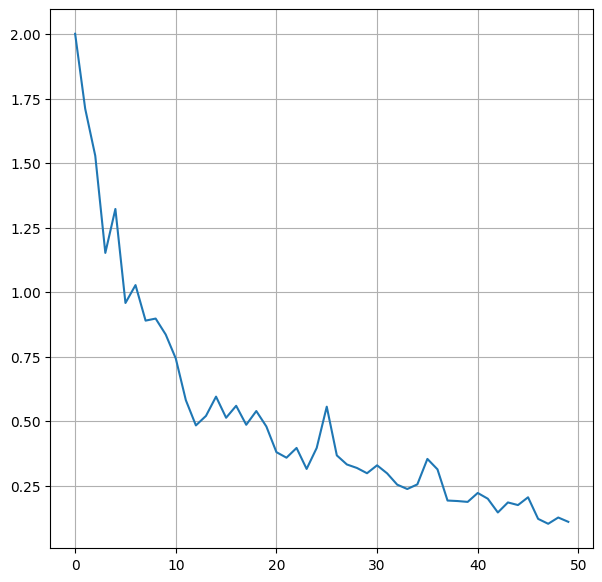

In [24]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.ylabel('Loss') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation'], loc='upper right') 
#plt.savefig("loss_curve.pdf") 
#plt.show()
#plt.figure(figsize=(5,5)) 
#plt.ylim(0,1.1) 
#plt.grid() 
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.ylabel('Accuracy') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation']) 
#plt.savefig("acc_curve.pdf") 
#plt.show()

In [25]:
# load best weightse
model.load_weights("best-model_PU_3DCNN_HSI.keras")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [26]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(14278, 12, 12, 3, 1)

In [27]:
ytest = to_categorical(ytest)
ytest.shape

(14278, 15)

In [28]:
start_time = time.time()

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

end_time = time.time()  # End timing
test_time = end_time - start_time  # Calculate the test time
print(f'Test time: {test_time:.2f} seconds')

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
Test time: 6.24 seconds
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1188
           1       0.87      0.97      0.92      1191
           2       0.95      1.00      0.97       662
           3       0.95      0.96      0.95      1182
           4       0.98      1.00      0.99      1180
           5       0.98      0.82      0.89       309
           6       0.87      0.88      0.88      1205
           7       0.73      0.92      0.81      1182
           8       0.89      0.92      0.91      1189
           9       0.95      0.86      0.90      1166
          10       0.97      0.93      0.95      1173
          11       0.94      0.77      0.84      1171
          12       0.89      0.91      0.90       446
          13       0.90      0.98      0.94       407
          14       0.98      0.80      0.88       627

    accuracy                           0.91     14278
   macro avg  

In [29]:
# Overall Accuracy
oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)# Level one decomposition
# Confusion Matrix
cm = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
# Calculate per-class accuracy from the confusion matrix
class_accuracy = cm.diagonal() / cm.sum(axis=1)
# Average Accuracy
aa = np.mean(class_accuracy)

# Kappa Coefficient
kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)

print(f'Overall Accuracy (OA): {oa:.4f}')
print(f'Average Accuracy (AA): {aa:.4f}')
print(f'Kappa Coefficient: {kappa:.4f}')
for i, acc in enumerate(class_accuracy): print(f'Class {i+1} Accuracy: {acc:.4f}')

Overall Accuracy (OA): 0.9126
Average Accuracy (AA): 0.9100
Kappa Coefficient: 0.9055
Class 1 Accuracy: 0.9453
Class 2 Accuracy: 0.9681
Class 3 Accuracy: 0.9955
Class 4 Accuracy: 0.9560
Class 5 Accuracy: 1.0000
Class 6 Accuracy: 0.8220
Class 7 Accuracy: 0.8797
Class 8 Accuracy: 0.9171
Class 9 Accuracy: 0.9209
Class 10 Accuracy: 0.8576
Class 11 Accuracy: 0.9258
Class 12 Accuracy: 0.7652
Class 13 Accuracy: 0.9126
Class 14 Accuracy: 0.9803
Class 15 Accuracy: 0.8038


In [39]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [49]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [50]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

1523/1523 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - accuracy: 0.9999 - loss: 4.3089e-04


In [51]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [52]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [53]:
# load the original image
X, y = loadData(dataset)

In [54]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [55]:
K = 3
X,fa = applyFA(X, numComponents=K)


In [56]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


C:\Users\ranja\AppData\Local\Temp\ipykernel_21560\1944015956.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

C:\Users\Utkarsh Trehan\anaconda3\envs\MALIS\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning:


The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

C:\Users\Utkarsh Trehan\anaconda3\envs\MALIS\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



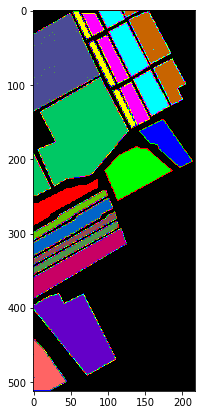

In [43]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

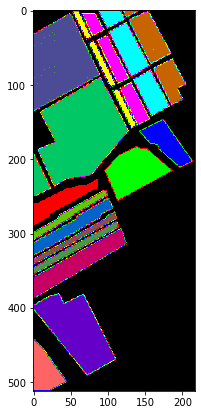

In [44]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [45]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)